In [1]:
import torch
import yfinance as yf
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pandas as pd
import os
import gpytorch
import argparse
import datetime

from botorch.models import SingleTaskGP
from botorch.optim.fit import fit_gpytorch_torch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import SpectralMixtureKernel, MaternKernel, RBFKernel, ScaleKernel
from voltron.means import EWMAMean, DEWMAMean, TEWMAMean
from voltron.train_utils import LearnGPCV, TrainVolModel, TrainVoltMagpieModel, TrainBasicModel
from voltron.models import VoltMagpie
from voltron.means import LogLinearMean

from voltron.rollout_utils import GeneratePrediction, Rollouts
from voltron.data import make_ticker_list, DataGetter, GetStockHistory

Warning no robinhood utils.


In [2]:
!nvidia-smi

Mon Dec 20 07:56:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    On   | 00000000:1A:00.0 Off |                  N/A |
| 41%   32C    P8    11W / 280W |  16782MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN RTX    On   | 00000000:1B:00.0 Off |                  N/A |
| 41%   

In [3]:
all_y = yf.download("XOM", start = "2020-06-01", end="2020-11-01", interval="1h").Close.values

[*********************100%***********************]  1 of 1 completed


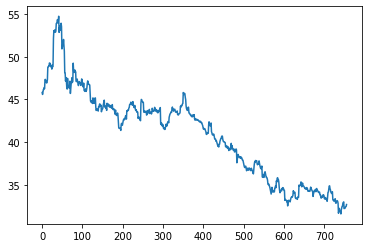

In [4]:
plt.plot(all_y)

In [5]:
dt = 1 / 252 / 8

In [6]:
ntrain = 400

In [7]:
device = torch.device("cuda:2")

In [8]:
train_y = torch.tensor(all_y[:ntrain]).view(-1).float().to(device)
train_x = torch.linspace(0, ntrain-1, ntrain-1).view(-1).to(device) * dt

test_y = torch.tensor(all_y[ntrain:]).view(-1).float().to(device)
test_x = torch.linspace(0, test_y.shape[0], test_y.shape[0]).view(-1).to(device) * dt + train_x[-1] + dt

In [9]:
train_x[-10:]

tensor([0.1934, 0.1939, 0.1944, 0.1949, 0.1954, 0.1959, 0.1964, 0.1969, 0.1974,
        0.1979], device='cuda:2')

In [10]:
test_x[:10]

tensor([0.1984, 0.1989, 0.1994, 0.1999, 0.2004, 0.2009, 0.2014, 0.2019, 0.2024,
        0.2029], device='cuda:2')

In [11]:
train_x.shape

torch.Size([399])

In [12]:
test_x.shape

torch.Size([356])

In [13]:
%pdb

Automatic pdb calling has been turned ON


In [14]:
with gpytorch.settings.max_cholesky_size(2000):
    vol = LearnGPCV(train_x, train_y, train_iters=200,
                        printing=True, kernel="fbm")
    vmod, vlh = TrainVolModel(train_x, vol / 8, 
                              train_iters=200, printing=True, kernel="fbm")
    voltron, lh = TrainVoltMagpieModel(train_x, train_y[1:], 
                                       vmod, vlh, vol / 8,
                                       printing=True, 
                                       train_iters=100,
                                       k=200, mean_func="ewma")

/home/wesley_m/gpytorch/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iter 1/200 - Loss: 363.720
Iter 51/200 - Loss: 28.356
Iter 101/200 - Loss: 12.173
Iter 151/200 - Loss: 7.646
Iter 1/200 - Loss: 1.053
Iter 51/200 - Loss: 0.932
Iter 101/200 - Loss: 0.844
Iter 151/200 - Loss: 0.797


/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iter 1/100 - Loss: 0.739
Iter 51/100 - Loss: -1.560


In [15]:
vmod.eval();

In [16]:
nsample = 1000

In [ ]:
save_samples = Rollouts(train_x, train_y, test_x, voltron, 
                        nsample=1000)
# voltron.vol_model.eval()
# predvol = voltron.vol_model(test_x).sample(torch.Size((nsample, ))).exp()
# save_samples = GeneratePrediction(train_x, train_y, test_x, 
#                              predvol, voltron).detach()

In [ ]:
save_samples.shape

In [ ]:
predictions = save_samples.exp()

In [ ]:
plt.plot(train_x.cpu(), train_y[1:].cpu())
plt.plot(test_x.cpu(), test_y.cpu())
plt.plot(test_x.cpu(), predictions.mean(0).cpu())
plt.fill_between(test_x.cpu(), predictions.mean(0).cpu() - 2 * predictions.std(0).cpu(),
                 predictions.mean(0).cpu() + 2 * predictions.std(0).cpu(),
                 color = "green", alpha = 0.2
                )
# plt.ylim((3, 8))

In [ ]:
plt.plot(train_x.cpu(), vol.cpu() / 8)

In [ ]:
vmod.covar_module.vol